# Complete Clsuter Classification

### by Katsiaryna Tsishchankava and Anton Krieger

This project aims at automatically classifying clusters of signals recorded from neurons in the human brain. This is the second of two Neural networks that is tested within this project. This time the input data will not be in the form of single spikes, but rather in form of a 2D-density plot of spikes that form a cluster. Multiple signals (spikes) form a cluster and are given one of the following labels: 
1. Single-unit (SU)
2. Multi-unit (MU)
3. Artefact (A)

Data from manually labeled clusters is used as input for training and testing a neural network. 

Data was provided by Marcel Kehl and Florian Mormann from the Department of Epileptology, University of Bonn Medical Center.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# helper contains various functions, 
# which are used throughout this project
from helper import *

%matplotlib inline
%pylab inline

# The first NN has label NN=1
NN=2

2022-01-30 16:23:20.362951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akrieger/polaris/CCfits/.libs/:/home/akrieger/polaris/cfitsio:/home/akrieger/polaris/CCfits/.libs/:/home/akrieger/polaris/cfitsio::/home/akrieger/Dokumente/cfitsio:/home/akrieger/lib:/home/akrieger/.openmpi/lib/
2022-01-30 16:23:20.362986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Populating the interactive namespace from numpy and matplotlib


In [3]:
# load train+dev set and 4 tests
# the data was generated using ./density_plot.ipynb
data,data_t1,data_t2,data_t3,data_t4 = load_complete_train_dev_plus_tests(
                                            NN=NN,
                                            load_train_dev=True, 
                                            load_tests=True,
                                            include_fpath=False)

# shuffle train+dev data
data = data.sample(frac=1,random_state=42).reset_index(drop=True)

# view 6 exemplary columns of the input data and the label column
data[["0","1","3231","3232","6462","6463","unitClass"]].head()

,0,1,3231,3232,6462,6463,unitClass
0,0.0,0.0,0.002223,0.002382,0.0,0.0,MU
1,0.0,0.0,0.002083,0.002431,0.0,0.0,MU
2,0.0,0.0,0.000528,0.000765,0.0,0.0,A
3,0.0,0.0,0.002831,0.003196,0.0,0.0,SU
4,0.0,0.0,0.004242,0.004186,0.0,0.0,SU


In [9]:
# this is the number of bins used for the density plots, 
# which was chosen to be 101
n_bin = 101

# read train+dev
x_tot,y_tot = read_input(data,NN,n_bin=n_bin,is_test=False)

# split train/dev
train_ratio = 0.9
m_train = int(x_tot.shape[0]*train_ratio)

x_train, y_train = x_tot[:m_train], y_tot[:m_train]
x_test, y_test = x_tot[m_train:], y_tot[m_train:]

# read test data
x_t1, y_t1 = read_input(data_t1,NN,n_bin=n_bin,is_test=True)
x_t2, y_t2 = read_input(data_t2,NN,n_bin=n_bin,is_test=True)
x_t3, y_t3 = read_input(data_t3,NN,n_bin=n_bin,is_test=True)
x_t4, y_t4 = read_input(data_t4,NN,n_bin=n_bin,is_test=True)


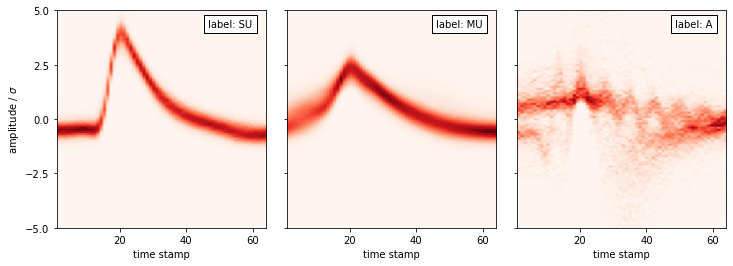

In [6]:
# example plot for how the input looks like
fig,axes = plt.subplots(1,3,figsize=(12,4),sharey='row')
plt.subplots_adjust(wspace=0.1)
extent = [1,64,-5,5]

for ii,i in enumerate([19,10,11]):
    
    axes[ii].imshow(x_train[i],origin='lower',cmap="Reds",aspect="auto",extent=extent,)
    axes[ii].set_yticks([-5,-2.5,0,2.5,5])
    axes[ii].set_xlabel("time stamp")
    if ii==0: axes[ii].set_ylabel(r"amplitude / $\sigma$")
    axes[ii].text(60,4.6,f"label: "+get_label_from_number(y_train[i]),
             verticalalignment="top",horizontalalignment="right",
             bbox=dict(facecolor='white', alpha=1))

plt.savefig(f"./figs/density_plot_examples.png",bbox_inches="tight",dpi=300)

In [7]:
def create_model(n_bin=101):
    input_shape = (n_bin,64,1)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(1, 1), activation="tanh", input_shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="tanh"),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="tanh"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3)
    ])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer_fn,
                  loss=loss_fn,
                  metrics=['accuracy'])
    
    return model

In [10]:
# initialize model
model = create_model(n_bin)

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), validation_steps=1, batch_size=32)

model.evaluate(x_test,  y_test, verbose=2)

model.save_weights('./checkpoints/NN2_density_epochs10')


2022-01-28 10:45:09.774118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akrieger/polaris/CCfits/.libs/:/home/akrieger/polaris/cfitsio:/home/akrieger/polaris/CCfits/.libs/:/home/akrieger/polaris/cfitsio::/home/akrieger/Dokumente/cfitsio:/home/akrieger/lib:/home/akrieger/.openmpi/lib/
2022-01-28 10:45:09.774178: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-28 10:45:09.774215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dwarf35): /proc/driver/nvidia/version does not exist


Epoch 1/10
88/88 [==============================] - 324s 4s/step - loss: 1.0676 - accuracy: 0.4979 - val_loss: 0.8966 - val_accuracy: 0.5312
Epoch 2/10
88/88 [==============================] - 322s 4s/step - loss: 0.9393 - accuracy: 0.6708 - val_loss: 0.7404 - val_accuracy: 0.6875
Epoch 3/10
88/88 [==============================] - 323s 4s/step - loss: 0.4967 - accuracy: 0.8239 - val_loss: 0.5877 - val_accuracy: 0.7812
Epoch 4/10
88/88 [==============================] - 325s 4s/step - loss: 0.4722 - accuracy: 0.8260 - val_loss: 0.5149 - val_accuracy: 0.7812
Epoch 5/10
88/88 [==============================] - 326s 4s/step - loss: 0.5222 - accuracy: 0.7997 - val_loss: 0.5213 - val_accuracy: 0.7188
Epoch 6/10
88/88 [==============================] - 325s 4s/step - loss: 0.4188 - accuracy: 0.8434 - val_loss: 0.4857 - val_accuracy: 0.7812
Epoch 7/10
88/88 [==============================] - 326s 4s/step - loss: 0.4576 - accuracy: 0.8288 - val_loss: 0.6721 - val_accuracy: 0.7188
Epoch 8/10
88

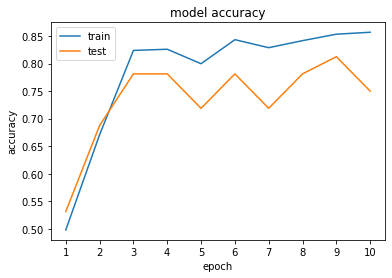

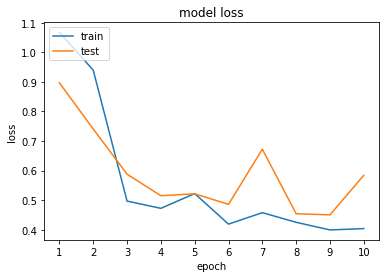

In [12]:
import matplotlib.pyplot as plt

def plt_history(history):
    # taken and slightly modified
    # from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    epochs = range(1,len(history.history['accuracy'])+1)
    
    # summarize history for accuracy
    plt.plot(epochs,history.history['accuracy'])
    plt.plot(epochs,history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(epochs)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(epochs,history.history['loss'])
    plt.plot(epochs,history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(epochs)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plt_history(history)

In [ ]:
# show results for testing sets
model = create_model(n_bin)
model.load_weights('./checkpoints/NN2_density_epochs10')


Next we calculate the accuracy for predictions of cluster labels as well as the F1-score. 
The shown confusion matrix  (Complete Cluster) shows the performance for each label individually. 

5/5 - 4s - loss: 0.5554 - accuracy: 0.8250 - 4s/epoch - 851ms/step
5/5 - 4s - 4s/epoch - 840ms/step
F1-score: 0.8089140176445877


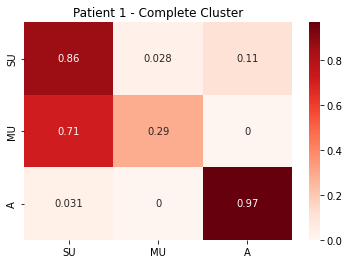

In [17]:
test_single_cluster(model,data_t1,x_t1,y_t1,patient_number=1,save_figure=True,NN=2)

7/7 - 6s - loss: 0.4842 - accuracy: 0.8261 - 6s/epoch - 801ms/step
7/7 - 6s - 6s/epoch - 788ms/step
F1-score: 0.7871614452715963


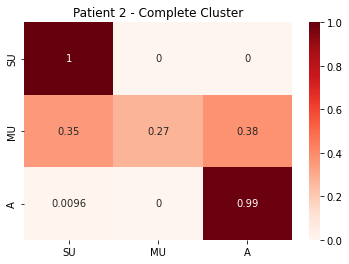

In [18]:
test_single_cluster(model,data_t2,x_t2,y_t2,patient_number=2,save_figure=True,NN=2)


6/6 - 5s - loss: 0.3919 - accuracy: 0.8737 - 5s/epoch - 838ms/step
6/6 - 5s - 5s/epoch - 848ms/step
F1-score: 0.8710627676477917


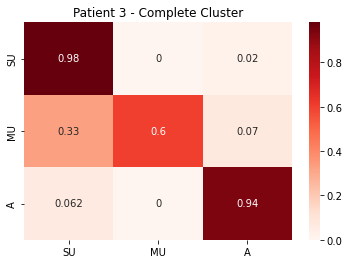

In [19]:
test_single_cluster(model,data_t3,x_t3,y_t3,patient_number=3,save_figure=True,NN=2)


7/7 - 5s - loss: 0.4207 - accuracy: 0.8195 - 5s/epoch - 768ms/step
7/7 - 5s - 5s/epoch - 779ms/step
F1-score: 0.8015986882557902


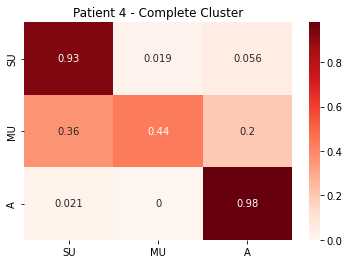

In [20]:
test_single_cluster(model,data_t4,x_t4,y_t4,patient_number=4,save_figure=True,NN=2)


Since 10 epochs was not leading to overfitting, the training of the model was continued by another 20 epochs.

In [13]:
# continue training for 20 more epochs
history2 = model.fit(x_train, y_train, epochs=20, validation_data=(x_test,y_test), validation_steps=1, batch_size=32)

model.evaluate(x_test,  y_test, verbose=2)

model.save_weights('./checkpoints/NN2_density_epochs30')

Epoch 1/20
88/88 [==============================] - 250s 3s/step - loss: 0.4124 - accuracy: 0.8455 - val_loss: 0.4300 - val_accuracy: 0.7812
Epoch 2/20
88/88 [==============================] - 250s 3s/step - loss: 0.4058 - accuracy: 0.8519 - val_loss: 0.4101 - val_accuracy: 0.7812
Epoch 3/20
88/88 [==============================] - 249s 3s/step - loss: 0.4399 - accuracy: 0.8409 - val_loss: 0.4322 - val_accuracy: 0.8750
Epoch 4/20
88/88 [==============================] - 250s 3s/step - loss: 0.3636 - accuracy: 0.8683 - val_loss: 0.3404 - val_accuracy: 0.8750
Epoch 5/20
88/88 [==============================] - 250s 3s/step - loss: 0.3641 - accuracy: 0.8722 - val_loss: 0.3704 - val_accuracy: 0.8438
Epoch 6/20
88/88 [==============================] - 250s 3s/step - loss: 0.3497 - accuracy: 0.8775 - val_loss: 0.4242 - val_accuracy: 0.7812
Epoch 7/20
88/88 [==============================] - 250s 3s/step - loss: 0.3754 - accuracy: 0.8675 - val_loss: 0.5272 - val_accuracy: 0.8125
Epoch 8/20
88

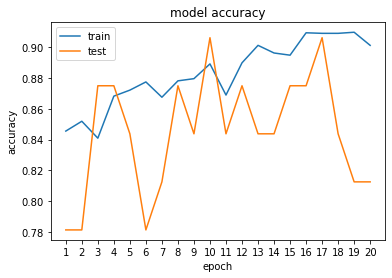

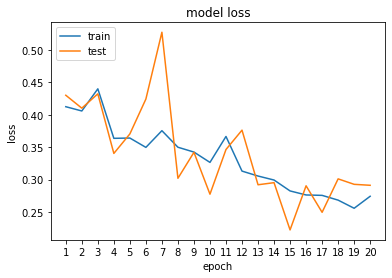

In [14]:
plt_history(history2)

In [22]:
# show results for testing sets
model = create_model(n_bin)
model.load_weights('./checkpoints/NN2_density_epochs30')


5/5 - 4s - loss: 0.5063 - accuracy: 0.8687 - 4s/epoch - 872ms/step
5/5 - 4s - 4s/epoch - 864ms/step
F1-score: 0.8611076555023924


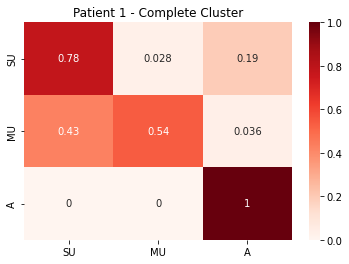

In [23]:
test_single_cluster(model,data_t1,x_t1,y_t1,patient_number=1,save_figure=True,NN=2)

7/7 - 6s - loss: 0.3006 - accuracy: 0.9082 - 6s/epoch - 795ms/step
7/7 - 6s - 6s/epoch - 790ms/step
F1-score: 0.9069041918843247


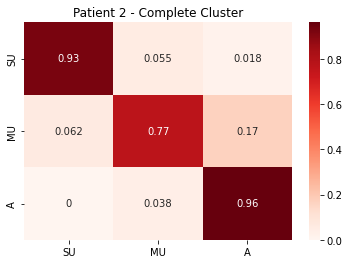

In [24]:
test_single_cluster(model,data_t2,x_t2,y_t2,patient_number=2,save_figure=True,NN=2)


6/6 - 5s - loss: 0.1970 - accuracy: 0.9316 - 5s/epoch - 835ms/step
6/6 - 5s - 5s/epoch - 843ms/step
F1-score: 0.9320123509396973


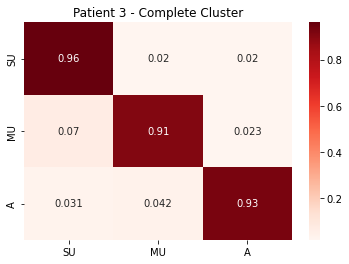

In [25]:
test_single_cluster(model,data_t3,x_t3,y_t3,patient_number=3,save_figure=True,NN=2)


7/7 - 5s - loss: 0.3166 - accuracy: 0.9122 - 5s/epoch - 780ms/step
7/7 - 5s - 5s/epoch - 781ms/step
F1-score: 0.911427257477797


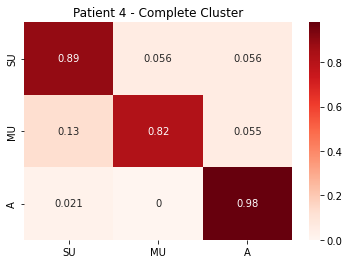

In [26]:
test_single_cluster(model,data_t4,x_t4,y_t4,patient_number=4,save_figure=True,NN=2)
